<a href="https://colab.research.google.com/github/EzpieCo/pytorch-crash-course-official/blob/main/04_non_linearity_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04 Non-linearity

GitHub repository: https://github.com/ezpie1/PyTorch-Crash-Course

Crash Course: https://ezpie.vercel.app/courses/machine-learning

In case of an question: https://github.com/ezpie1/PyTorch-Crash-Course/discussions

---

**Simple definition of non-lineary:** In non-lineary we convert a stright line into a curve

## Chapter: Creating the dataset

In order for us to classify we need data. Cause it's common sence!

In [ ]:
#@title importing required libraries

import torch
from torch import nn
import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

X, y = make_circles(1000, # simple of dots
                    noise=0.05, # some randomness
                    random_state=23) # the same thing - the dataset should be same even after multiple runs

In [ ]:
#@title Make dataFrame of circle data

circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head() # first five(5) values

,X1,X2,label
0,0.768261,0.157294,1
1,-0.426287,-0.642347,1
2,-0.889509,0.482045,0
3,0.765902,0.283268,1
4,0.843128,-0.194731,1


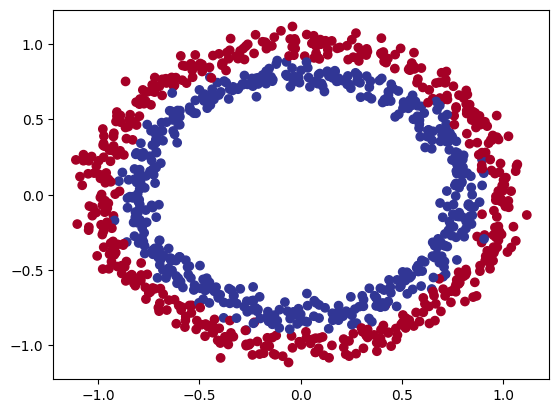

In [ ]:
#@title Visualize the data

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [ ]:
#@title convert numpy data type to pytorch data type.

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
#@title Splitting data into training and testing

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Chapter: Creating the model

Quick overview of what a model has:

A model has a network of neurons. The model is made by sub classing `nn.Module`.

In [ ]:
#@title Neural Network for classifing the data

class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(2, 10)
    self.layer2 = nn.Linear(10, 10)
    self.layer3 = nn.Linear(10, 1)

  def forward(self, x):
    return self.layer3(self.layer2(self.layer1(x)))  # x -> layer1 -> layer2 -> output

model1 = CircleModel().to(device)
model1

CircleModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss() # Has the sigmoid activation function

optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr=0.1)

In [ ]:
# Calculate accuracy | Way to check how *good* the model is doing
def accuracy(y_pred, y_true):
  correct = torch.eq(y_true, y_pred).sum().item()
  accuracy = (correct/len(y_pred)) * 100
  return accuracy

In [ ]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
def trainer(epochs=100):

  for epoch in range(epochs):
    model1.train()

    # Predict
    train_logit = model1(X_train).squeeze()
    train_pred = torch.round(torch.sigmoid(train_logit)) # logits -> probabilities -> labels

    # calculate loss and accuracy
    train_loss = loss_fn(train_logit, y_train)
    train_acc = accuracy(train_pred, y_train)

    # Optimizer zero grad
    optimizer.zero_grad()

    # backpropagation
    train_loss.backward()

    # Gradient decent
    optimizer.step()

    model1.eval()
    with torch.no_grad():
      test_logit = model1(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logit))

      # calculate loss and accuracy
      test_loss = loss_fn(test_logit, y_test)
      test_acc = accuracy(test_pred, y_test)

    if epoch % 20 == 0:
      print(f'Epoch: {epoch} | Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%')

trainer()

Epoch: 0 | Train loss: 0.69729 | Train accuracy: 50.38% | Test loss: 0.70532 | Test accuracy: 48.50%
Epoch: 20 | Train loss: 0.69326 | Train accuracy: 49.50% | Test loss: 0.69888 | Test accuracy: 43.50%
Epoch: 40 | Train loss: 0.69299 | Train accuracy: 49.38% | Test loss: 0.69773 | Test accuracy: 47.50%
Epoch: 60 | Train loss: 0.69291 | Train accuracy: 49.75% | Test loss: 0.69724 | Test accuracy: 47.00%
Epoch: 80 | Train loss: 0.69286 | Train accuracy: 49.75% | Test loss: 0.69693 | Test accuracy: 48.00%


### Checking the problem

Since We have a problem, that is the accuracy is around 50%

In [ ]:
def plot_decision_boundary(model, X, y):
  # Numpy and matplot work well with CPU
  model.to("cpu")
  X, y = X.to("cpu"), y.to("cpu")

  # Setup prediction boundaries and grid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

  # Make features
  X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

  # Make predictions
  model.eval()
  with torch.inference_mode():
    y_logits = model(X_to_pred_on)

  # Logits -> Probabilities -> Prediction Labels
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Reshape preds and plot
  y_pred = y_pred.reshape(xx.shape).detach().numpy()
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

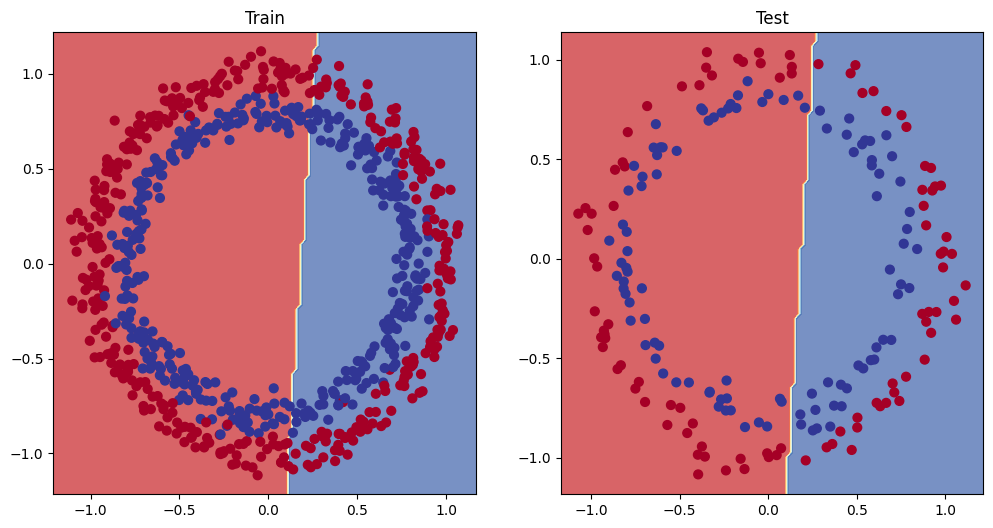

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test)

## Chapter: Adding non-linearity

In [ ]:
#@title Recreating the model with non-linear activation function

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(2, 10)
    self.layer2 = nn.Linear(10, 10)
    self.layer3 = nn.Linear(10, 1)
    self.relu = nn.ReLU() # Non-linear activaion function

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model2 = CircleModelV2().to(device)
model2

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# Loss function
lossFn = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.SGD(params=model2.parameters(),
                            lr=0.1)

In [ ]:
# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
#@title Preparing the training loop

torch.manual_seed(32)
torch.cuda.manual_seed(32)

def trainer2(epochs=1000):

  for epoch in range(epochs):
    model2.train()

    # Predict
    train_logit = model2(X_train).squeeze()
    train_pred = torch.round(torch.sigmoid(train_logit)) # logits -> probabilities -> labels

    # calculate loss and accuracy
    train_loss = loss_fn(train_logit, y_train)
    train_acc = accuracy(train_pred, y_train)

    # Optimizer zero grad
    optimizer.zero_grad()

    # backpropagation
    train_loss.backward()

    # Gradient decent
    optimizer.step()

    model2.eval()
    with torch.inference_mode():
      test_logit = model2(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logit))

      # calculate loss and accuracy
      test_loss = loss_fn(test_logit, y_test)
      test_acc = accuracy(test_pred, y_test)

    if epoch % 10 == 0:
      print(f'Epoch: {epoch} | Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%')

trainer2()

Epoch: 0 | Train loss: 0.69544 | Train accuracy: 43.38% | Test loss: 0.69415 | Test accuracy: 45.00%
Epoch: 10 | Train loss: 0.69510 | Train accuracy: 43.12% | Test loss: 0.69392 | Test accuracy: 45.00%
Epoch: 20 | Train loss: 0.69480 | Train accuracy: 43.25% | Test loss: 0.69374 | Test accuracy: 45.00%
Epoch: 30 | Train loss: 0.69452 | Train accuracy: 44.75% | Test loss: 0.69361 | Test accuracy: 46.50%
Epoch: 40 | Train loss: 0.69425 | Train accuracy: 47.88% | Test loss: 0.69351 | Test accuracy: 47.50%
Epoch: 50 | Train loss: 0.69399 | Train accuracy: 50.25% | Test loss: 0.69343 | Test accuracy: 48.50%
Epoch: 60 | Train loss: 0.69374 | Train accuracy: 50.38% | Test loss: 0.69336 | Test accuracy: 48.50%
Epoch: 70 | Train loss: 0.69350 | Train accuracy: 50.38% | Test loss: 0.69330 | Test accuracy: 48.50%
Epoch: 80 | Train loss: 0.69327 | Train accuracy: 50.38% | Test loss: 0.69324 | Test accuracy: 48.50%
Epoch: 90 | Train loss: 0.69305 | Train accuracy: 50.38% | Test loss: 0.69318 | Tes

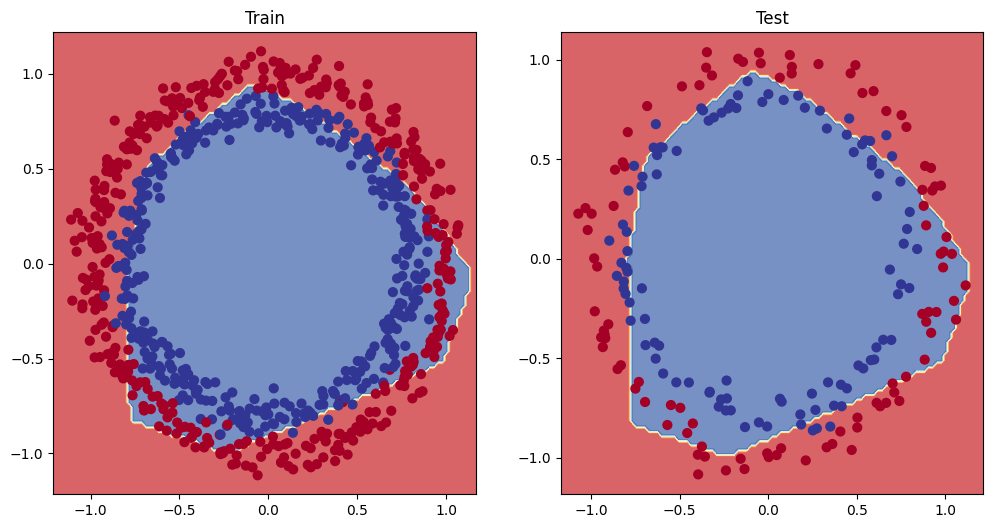

In [ ]:
#@title Ploter function to check the decison boundary

def ploter():
  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.title("Train")
  plot_decision_boundary(model2, X_train, y_train)

  plt.subplot(1, 2, 2)
  plt.title("Test")
  plot_decision_boundary(model2, X_test, y_test)

ploter()

## Chapter: Imporving the model

In order to imporve the model's performence we can do it in two perspectives

- Model perspective
- Data perspective

Since we can adjust our data we can just add more data points and make the model learn, but in real world problems we may not always have this.

For this case we will upgrade our model by these adjusting these values

- Number of hidden layers
- Number of neurons per hidden layer
- train for longer epochs

In [ ]:
#@title imporvement by training longer

# Let's try the easiest method, that is longer training

trainer2()

Epoch: 0 | Train loss: 0.60726 | Train accuracy: 80.12% | Test loss: 0.62644 | Test accuracy: 74.00%
Epoch: 10 | Train loss: 0.60288 | Train accuracy: 80.25% | Test loss: 0.62246 | Test accuracy: 76.00%
Epoch: 20 | Train loss: 0.59825 | Train accuracy: 82.38% | Test loss: 0.61831 | Test accuracy: 77.00%
Epoch: 30 | Train loss: 0.59339 | Train accuracy: 82.88% | Test loss: 0.61394 | Test accuracy: 77.50%
Epoch: 40 | Train loss: 0.58828 | Train accuracy: 82.38% | Test loss: 0.60941 | Test accuracy: 78.00%
Epoch: 50 | Train loss: 0.58293 | Train accuracy: 82.75% | Test loss: 0.60465 | Test accuracy: 78.00%
Epoch: 60 | Train loss: 0.57734 | Train accuracy: 82.75% | Test loss: 0.59962 | Test accuracy: 78.00%
Epoch: 70 | Train loss: 0.57149 | Train accuracy: 82.62% | Test loss: 0.59433 | Test accuracy: 78.00%
Epoch: 80 | Train loss: 0.56539 | Train accuracy: 83.00% | Test loss: 0.58876 | Test accuracy: 79.50%
Epoch: 90 | Train loss: 0.55902 | Train accuracy: 83.62% | Test loss: 0.58298 | Tes

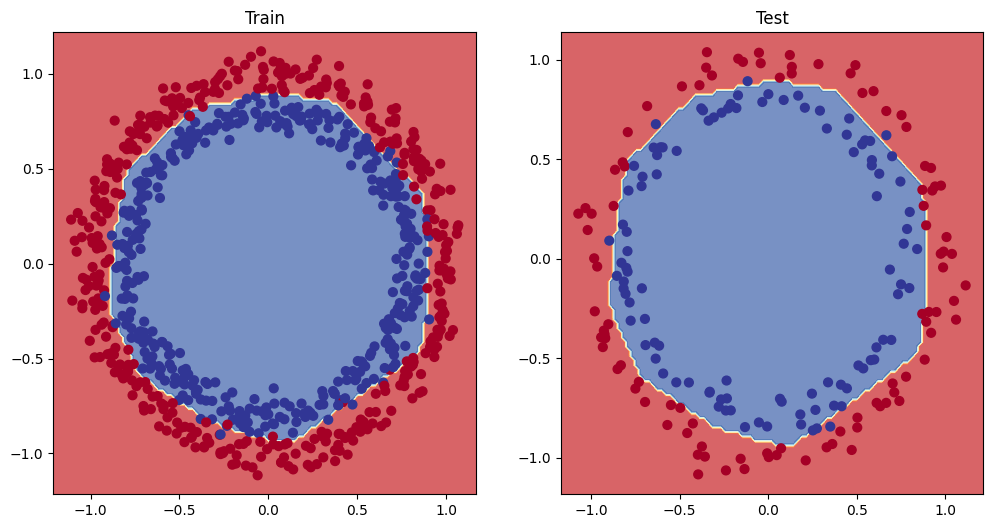

In [ ]:
ploter()